##### <p> Samuel Wolfe <br> September 10, 2023 <br> MSBA 206 <br> DMBA Chapter 13.2</p>

In [76]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import requests
import io
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns

In [77]:

from sklearn.ensemble import AdaBoostClassifier , RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import scikitplot as skplt
import matplotlib.pylab as plt
from dmba import plotDecisionTree, classificationSummary, regressionSummary,liftChart

In [78]:
def readFile(url):
    download = requests.get(url).content
    # Reading the downloaded content and turning it into a pandas dataframe
    df = pd.read_csv(io.StringIO(download.decode('utf-8')))
    return df
def statslist(df):
    dfStats = pd.DataFrame({'Mean' : df.mean(numeric_only=True),
            'SD' : df.std(numeric_only=True),
            'Min' : df.min(),
            'Max' : df.max(),
            'Median' : df.median(numeric_only=True),
            })
    return dfStats
def categorize(df):
    for x in df:
        df[x] = df[x].astype('category')
    return df
def catStringToINT(df,col):
    names = []
    num = []
    for x in df[col].unique():
        names.append((df[col] == x))
    for x in range(len(names)):
        num.append(x+1)
    df[col] = np.select(names, num)
    return df

## DMBA Chapter 13 Question 4

In [79]:
dfHair = readFile("https://raw.githubusercontent.com/wolfesamk/MSBA-206/main/dmba/Hair-Care-Product.csv")

In [80]:
dfHair

,Purchase,Age,Hair Color,U.S. Region,Validation,Promotion_ord,Gender_ord,Residence_ord
0,0,25,Black,Southwest,1,1,0,1
1,0,30,Black,Northwest,1,0,0,1
2,0,45,Red,Northeast,1,0,0,0
3,0,35,Blond,Southwest,0,0,0,1
4,0,33,Brown,Southwest,0,1,0,1
...,...,...,...,...,...,...,...,...
9995,0,27,Blond,Northeast,0,1,0,1
9996,0,46,Brown,Northwest,1,1,1,1
9997,0,53,Brown,Northwest,0,0,0,1
9998,0,29,Blond,Northeast,0,0,0,1


In [81]:
dfHair.dtypes

Purchase          int64
Age               int64
Hair Color       object
U.S. Region      object
Validation        int64
Promotion_ord     int64
Gender_ord        int64
Residence_ord     int64
dtype: object

In [82]:
dfHair['Hair Color'] = dfHair['Hair Color'].astype('category')
dfHair['U.S. Region'] = dfHair['U.S. Region'].astype('category')
#dfHair['Promotion_ord'] = dfHair['Promotion_ord'].astype('category')
dfHair['Gender_ord'] = dfHair['Gender_ord'].astype('category')
dfHair['Residence_ord'] = dfHair['Residence_ord'].astype('category')

In [83]:
dfHair.dtypes

Purchase            int64
Age                 int64
Hair Color       category
U.S. Region      category
Validation          int64
Promotion_ord       int64
Gender_ord       category
Residence_ord    category
dtype: object

In [84]:
dfHair['Hair Color'].value_counts()

Hair Color
Brown    3819
Blond    3742
Black    1815
Red       624
Name: count, dtype: int64

In [85]:
dfHair.head(1)

,Purchase,Age,Hair Color,U.S. Region,Validation,Promotion_ord,Gender_ord,Residence_ord
0,0,25,Black,Southwest,1,1,0,1


In [86]:
XIII_a = pd.crosstab(dfHair.Purchase, dfHair.Promotion_ord, margins=True, margins_name='Total')
XIII_a

Promotion_ord,0,1,Total
Purchase,,,
0,4992,4896,9888
1,32,80,112
Total,5024,4976,10000


#### Propensity of purchasing among those who received the promotion.

In [87]:
XIII_a_i = round((80/4976)*100, 2)
XIII_a_i

1.61

#### Propensity of purchasing among those who did not receive the promotion.

In [88]:
XIII_a_ii = round((32/5024)*100, 2)
XIII_a_ii

0.64

In [89]:
dfHairDum = pd.get_dummies(dfHair, drop_first=False)

In [90]:
X_Hair = dfHairDum.drop(columns=['Validation','Purchase'])
Y_Hair = dfHairDum['Purchase']
X_train, X_valid, y_train, y_valid = train_test_split(X_Hair, Y_Hair, test_size=0.4, random_state=1)

#### Uplift with Random Forest

In [91]:
model = RandomForestClassifier(n_estimators=50, criterion='entropy', random_state=1)
model.fit(X_train, y_train)
model.score(X_valid, y_valid)
y_predicted = model.predict(X_valid)
classificationSummary(y_valid, y_predicted)

Confusion Matrix (Accuracy 0.9822)

       Prediction
Actual    0    1
     0 3929   19
     1   52    0


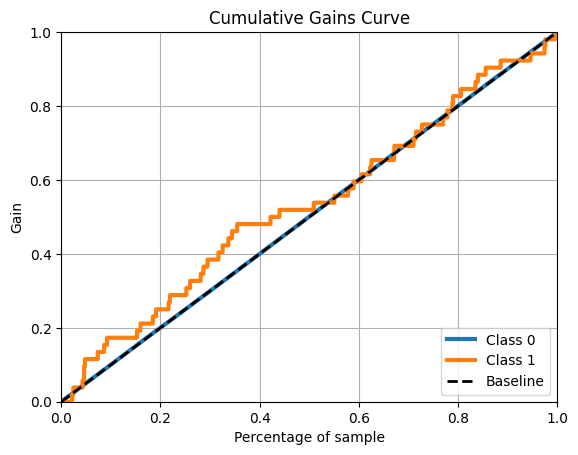

In [92]:
predicted_probas = model.predict_proba(X_valid)
skplt.metrics.plot_cumulative_gain(y_valid, predicted_probas)
plt.show()

In [93]:
df_predicted_probas = pd.DataFrame(predicted_probas)
df_predicted_probas['Predicted'] = df_predicted_probas[1]
df_predicted_probas = df_predicted_probas.drop(columns=[0,1])

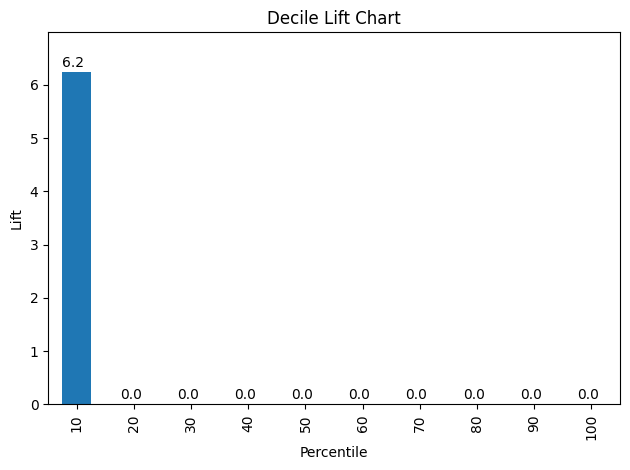

In [94]:
resultPredTrain = pd.DataFrame({'Predicted': df_predicted_probas['Predicted'], 'Actual': y_valid})
liftChart(resultPredTrain.sort_values(by=['Predicted'], ascending=False).Predicted, labelBars=True, title='Decile Lift Chart')
plt.tight_layout()
plt.show()

#### Uplift using K-NN

In [95]:
results = []
for k in range(1, 20, 1):
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    results.append({
        'k': k,
        'Accuracy': accuracy_score(y_valid, knn.predict(X_valid))
    })
results = pd.DataFrame(results)
results.sort_values(by='Accuracy', ascending=False).head(5)

,k,Accuracy
9,10,0.987
10,11,0.987
17,18,0.987
16,17,0.987
15,16,0.987


In [96]:
knn10 = KNeighborsClassifier(n_neighbors=5)
knn10.fit(X_train, y_train)


#training
knn10trPredOpt = knn10.predict(X_train)
print('Training')
print('Confusion Matrix: \n',confusion_matrix(y_train, knn10trPredOpt))
print('Accuracy:', accuracy_score(y_train, knn10trPredOpt))

#validation
knn10vPredOpt = knn10.predict(X_valid)
print('\nTraining')
print('Confusion Matrix: \n',confusion_matrix(y_valid, knn10vPredOpt))
print('Accuracy: ', accuracy_score(y_valid, knn10vPredOpt))

Training
Confusion Matrix: 
 [[5940    0]
 [  60    0]]
Accuracy: 0.99

Training
Confusion Matrix: 
 [[3948    0]
 [  52    0]]
Accuracy:  0.987


In [97]:
X_valid

,Age,Promotion_ord,Hair Color_Black,Hair Color_Blond,Hair Color_Brown,Hair Color_Red,U.S. Region_Northeast,U.S. Region_Northwest,U.S. Region_Southeast,U.S. Region_Southwest,Gender_ord_0,Gender_ord_1,Residence_ord_0,Residence_ord_1
9953,32,1,False,True,False,False,False,False,False,True,False,True,False,True
3850,51,1,True,False,False,False,False,False,True,False,True,False,False,True
4962,29,1,False,True,False,False,True,False,False,False,False,True,False,True
3886,56,1,False,False,True,False,False,True,False,False,False,True,False,True
5437,56,1,False,False,True,False,False,False,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9274,58,1,False,False,True,False,False,False,False,True,True,False,True,False
8946,26,1,False,False,True,False,True,False,False,False,False,True,False,True
7637,38,0,False,False,True,False,True,False,False,False,True,False,False,True
6377,49,1,False,False,True,False,False,False,True,False,True,False,False,True


#### RF first three predictions

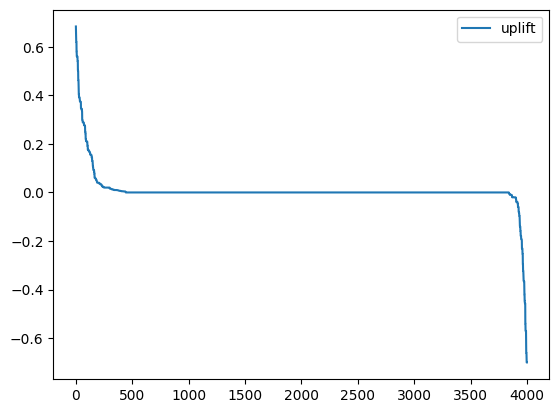

In [101]:
# Calculating the uplift
uplift_df = X_valid.copy() # Need to create a copy to allow modifying data
uplift_df.Promotion_ord = 1
predTreatment = model.predict_proba(uplift_df)
uplift_df.Promotion_ord = 0
predControl = model.predict_proba(uplift_df)
upliftResult_rf = pd.DataFrame({
    'probMessage': predTreatment[:,1],
    'probNoMessage': predControl[:,1],
    'uplift': predTreatment[:,1] - predControl[:,1],
    }, index=uplift_df.index)
#upliftResult_df.head(3)
upliftResult_rf = upliftResult_rf.sort_values(by=['uplift'], ascending=False)
upliftResult_rf.reset_index().plot(x=None, y='uplift')
plt.show()

In [102]:
upliftResult_rf

,probMessage,probNoMessage,uplift
1390,0.703333,0.02,0.683333
6757,0.680000,0.02,0.660000
4814,0.640000,0.00,0.640000
6751,0.620000,0.00,0.620000
201,0.620000,0.00,0.620000
...,...,...,...
1302,0.060000,0.72,-0.660000
5169,0.060000,0.72,-0.660000
299,0.000000,0.68,-0.680000
5881,0.040000,0.74,-0.700000


#### KNN first three predicitons

In [99]:
# Calculating the uplift
uplift_df = X_valid.copy() # Need to create a copy to allow modifying data
uplift_df.Promotion_ord = 1
predTreatment = knn10.predict_proba(uplift_df)
uplift_df.Promotion_ord = 0
predControl = knn10.predict_proba(uplift_df)
upliftResult_df = pd.DataFrame({
    'probMessage': predTreatment[:,1],
    'probNoMessage': predControl[:,1],
    'uplift': predTreatment[:,1] - predControl[:,1],
    }, index=uplift_df.index)
upliftResult_df.head(3)

,probMessage,probNoMessage,uplift
9953,0.0,0.0,0.0
3850,0.0,0.0,0.0
4962,0.0,0.0,0.0


## To be honest, I have no idea if I am doing this right. I feel like I am but the book is not particularly helpful for this content.